# Notebook for genome prediction analysis

Imports

In [2]:
import time
import os
import importlib

from pprint import pprint
from collections import defaultdict
from pathlib import Path
from more_itertools import grouper
from itertools import islice, chain, zip_longest, repeat

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax
import seaborn as sns

import scipy
from scipy import io
from scipy.signal import convolve
from scipy.sparse import coo_matrix, csr_matrix
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import cut_tree

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

from Modules import utils, plot_utils

Useful global variables

In [3]:
importlib.reload(utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Load chromosome

In [ ]:
chr_id = 1
overlapping_peaks = {}
# load one_hot_encoded sequence
chr_file = f'../shared_folder/Human/assembly/chr{chr_id}.npz'
with np.load(chr_file) as f:
    one_hot_chr = f['one_hot_genome']
window_size = 101
valid_window_idx = utils.remove_windows_with_N(one_hot_chr, window_size)
print('All windows:', len(one_hot_chr)-window_size+1)
N_mask = np.all(np.logical_not(one_hot_chr), axis=1)
print('Without N:', len(valid_window_idx))

# # load sequence with soft masked repeats
# with np.load(f'{data_dir}/Human/assembly/chr{chr_id}_seq.npz') as f:
#     chr_seq = f['reads'][0]
# chr_seq = np.array(list(chr_seq))
# repeats_idx, = np.where(chr_seq > 'Z')
# print(len(repeats_idx), 'bases in repeats')

# load repeat annotation
repeats = utils.parse_repeats(f'{data_dir}/Human/annotations/repeats/hg38.fa.out', window_size)
chr_repeats = repeats[f'{chr_id}']

All windows: 248956322
Without N: 230469111


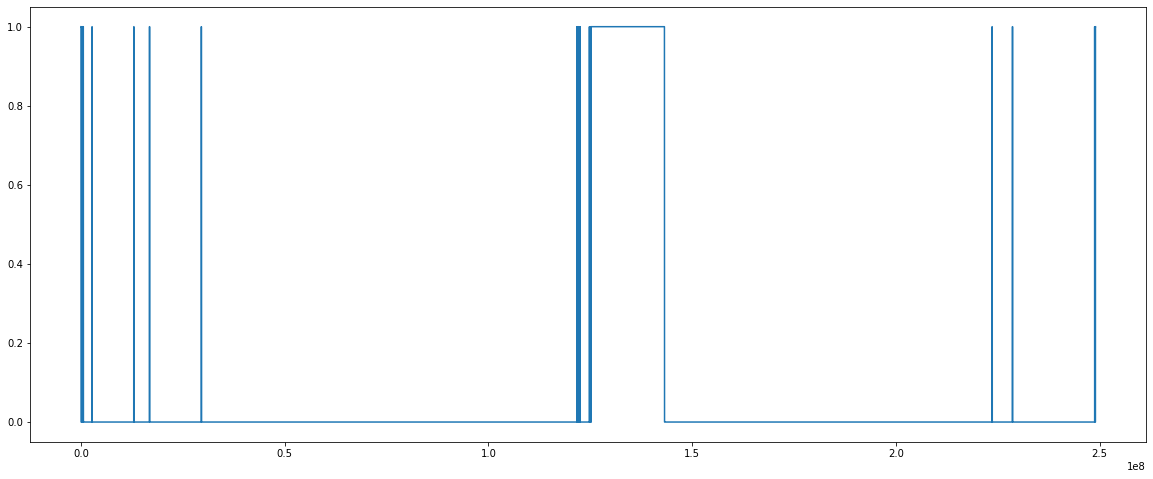

In [ ]:
start = 0 # 120_000_000
end = len(one_hot_chr) # 130_000_000
plt.figure(figsize=(20, 8))
plt.plot(np.arange(start, end), N_mask[start:end])
plt.show()
plt.close()

Load predictions

In [ ]:
data = 'H3K9me3'
model_name = 'model_inception2.2'
model_name1 = 'model_inception2.2.rep1'
model_name_rel = 'model_inception2.2_rel8'
pred_on_genome = True
relabeled = False
if pred_on_genome:
    with np.load(f'{data_dir}/{data}/results/{model_name}/preds_on_genome.npz') as f:
        preds0 = f[f'chr{chr_id}']
    with np.load(f'{data_dir}/{data}/results/{model_name1}/preds_on_genome.npz') as f:
        preds1 = f[f'chr{chr_id}']
    if relabeled:
        with np.load(f'{data_dir}/{data}/results/{model_name_rel}/preds_on_genome.npz') as f:
            preds_rel = f[f'chr{chr_id}']
else:
    with np.load(f'{data_dir}/{data}/results/{model_name}/preds_on_chr{chr_id}.npz') as f:
        preds0 = f['preds']
    with np.load(f'{data_dir}/{data}/results/{model_name1}/preds_on_chr{chr_id}.npz') as f:
        preds1 = f['preds']
    if relabeled:
        with np.load(f'{data_dir}/{data}/results/{model_name_rel}/preds_on_chr{chr_id}.npz') as f:
            preds_rel = f['preds']

Load peaks, logFC and p-value

In [ ]:
files = {
    'CTCF': {
        'peaks': 'ENCFF748YHT.bed',
        'p_value': 'ENCFF701JJR.bigWig',
        'logFC': 'ENCFF902EIC.bigWig',
    },
    'H3K27ac': {
        'peaks': 'ENCFF553YTG.bed',
        'p_value': 'ENCFF472QZS.bigWig',
        'logFC': 'ENCFF408XBB.bigWig',
    },
    'H3K27me3': {
        'peaks': 'ENCFF968KLE.bed',
        'p_value': 'ENCFF805LJE.bigWig',
        'logFC': 'ENCFF463LIU.bigWig',
    },
    'H3K9me3': {
        'peaks': 'ENCFF411TKR.bed',
        'p_value': 'ENCFF042EJN.bigWig',
        'logFC': 'ENCFF088IKU.bigWig',
    },
}
peaks_dict = utils.parse_bed_peaks(f'{data_dir}/{data}/raw_data/peaks/{files[data]["peaks"]}', window_size)
p_vals = utils.load_annotation(f'{data_dir}/{data}/raw_data/p_value/{files[data]["p_value"]}', chr_id, window_size)
log_fc = utils.load_annotation(f'{data_dir}/{data}/raw_data/logFC/{files[data]["logFC"]}', chr_id, window_size)
# alt_peaks_dict_CTCF = utils.parse_bed_peaks(f'{data_dir}/{data}/raw_data/peaks/ENCFF855IQA.bed', window_size)

# other_data = 'H3K27ac'
# other_peaks_dict = utils.parse_bed_peaks(f'{data_dir}/{other_data}/raw_data/peaks/{files[other_data]["peaks"]}', window_size)
# other_p_vals = utils.load_annotation(f'{data_dir}/{other_data}/raw_data/p_value/{files[other_data]["p_value"]}', chr_id, window_size)
# other_log_fc = utils.load_annotation(f'{data_dir}/{other_data}/raw_data/logFC/{files[other_data]["logFC"]}', chr_id, window_size)

Formatting of predicted signal

In [ ]:
# z-score, mean and smooth
preds = (preds0 + preds1)/2  # average both replicas
# change predictions on N windows to mean signal
valid_window_mask = np.zeros(len(preds), dtype=bool)
valid_window_mask[valid_window_idx] = True
preds = np.where(valid_window_mask, preds, np.mean(preds[valid_window_idx]))
# # z score
# z_score_preds = utils.z_score(preds, valid_window_idx)
# # Smooth mean
# smooth_size = window_size
# smooth = utils.smooth(preds, smooth_size, mode='linear')
# # z_score_smooth = utils.smooth(z_score_preds, smooth_size, mode='linear')
# log_fc_smooth = utils.smooth(log_fc, 101, mode='linear')
# p_vals_smooth = utils.smooth(p_vals, 101, mode='linear')

# # mean and std with or without windows containing Ns
# mean = np.mean(preds)
# std = np.std(preds)
# rel_preds = preds[valid_window_idx]
# rel_mean = np.mean(rel_preds)
# rel_std = np.std(rel_preds)
# print('mean and std for all windows:', mean, std)
# print('mean and std without Ns:', rel_mean, rel_std)

# # correlations between replicas
# inter_corr = pearsonr(preds0, preds1)
# print(inter_corr, 'correlation rep0-rep1')
# corr_mrel = pearsonr(preds, preds_rel)
# print(corr_mrel, 'correlation mean-relabeled')

p-value vs prediction

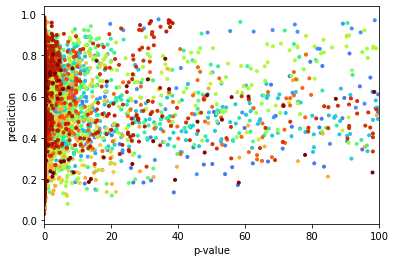

In [ ]:
start = 1_000_000
step = 10
stop = 50_000*step + start

color = range(start, stop, step)
plt.scatter(p_vals[valid_window_idx][start:stop:step], preds[valid_window_idx][start:stop:step], marker='.', c=color, cmap=plt.cm.get_cmap('turbo'), vmin=start, vmax=stop)
plt.xlabel('p-value')
plt.ylabel('prediction')
plt.xlim(0, 100)
plt.show()
plt.close()

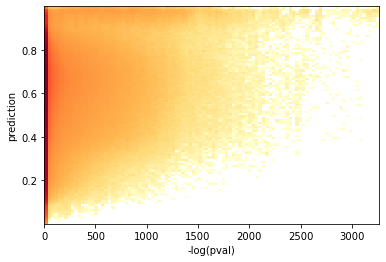

230469111 points drawn


In [ ]:
_, bin_edges_x = np.histogram(p_vals[valid_window_idx], bins=100)
_, bin_edges_y = np.histogram(preds[valid_window_idx], bins=100)
bin_edges = [bin_edges_x, bin_edges_y]
plt.hist2d(p_vals[valid_window_idx], preds[valid_window_idx], bins=bin_edges, density=True, norm=mpl.colors.LogNorm(), cmap=plt.cm.get_cmap('YlOrRd'))
plt.xlabel('-log(pval)')
plt.ylabel('prediction')
plt.show()
plt.close()
print(len(valid_window_idx), 'points drawn')

Without first bin in p-value

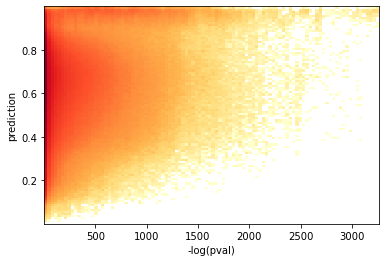

6835154 points drawn


In [ ]:
# remove first bin in p-value
# bin_edges[0] = bin_edges_x[1:]
bin_edges_x[0] = min(2, bin_edges_x[1])
bin_edges[0] = bin_edges_x
plt.hist2d(p_vals[valid_window_idx], preds[valid_window_idx], bins=bin_edges, density=True, norm=mpl.colors.LogNorm(), cmap=plt.cm.get_cmap('YlOrRd'))
plt.xlabel('-log(pval)')
plt.ylabel('prediction')
plt.show()
plt.close()
print(np.bincount(p_vals[valid_window_idx] >= bin_edges[0][0])[1], 'points drawn')

p-value distribution

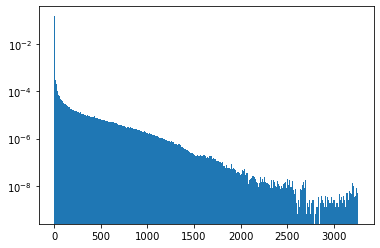

In [ ]:
plt.hist(p_vals[valid_window_idx], bins=500, density=True)
plt.yscale('log')
plt.show()
plt.close()

Peak selection on chromosome

In [ ]:
# Total peaks and only high ones
# adjust start and end to sliding window index
chr_peaks = peaks_dict[f'{chr_id}']
print(chr_peaks.shape, f'total peaks in {data}')
high_peaks = chr_peaks[chr_peaks[:,2] >= 1000]
print(high_peaks.shape, f'high peaks in {data}')
# # Peaks of different dataset
# alt_chr_peaks = alt_peaks_dict_CTCF[f'{chr_id}']
# print(alt_chr_peaks.shape, f'alternative peaks in {data}')

(698, 3) total peaks in H3K9me3
(0, 3) high peaks in H3K9me3


peak length analysis

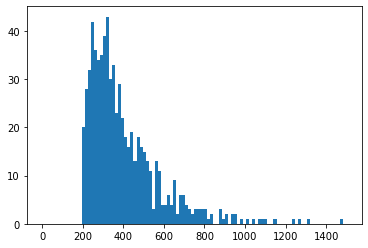

Number of bases in peaks: 279679


In [ ]:
# Distribution of peak lengths
peak_lengths = np.diff(chr_peaks[:, :2], axis=1).ravel()
plt.hist(peak_lengths, bins=100, range=(0, 1500))
plt.show()
plt.close()
# high_peaks_lengths = np.diff(high_peaks[:, :2], axis=1).ravel()
# plt.hist(high_peaks_lengths, bins=100)
# plt.show()
# plt.close()

# Total peak length
print('Number of bases in peaks:', np.sum(peak_lengths))

# # For CTCF, alternative peak lengths
# alt_peak_lengths = np.diff(alt_chr_peaks[:, :2], axis=1).ravel()
# plt.hist(alt_peak_lengths[alt_peak_lengths != 810], bins=100, range=(0, 1500))
# plt.show()
# plt.close()
# print('Number of bases in alternative peaks:', np.sum(alt_peak_lengths))

# print(len(peak_lengths[peak_lengths != 810]))
# print(len(alt_peak_lengths[alt_peak_lengths != 810]))
# chr_peaks_reg = chr_peaks[peak_lengths != 810]
# alt_chr_peaks_reg = alt_chr_peaks[alt_peak_lengths != 810]
# uniques, unique_indices = np.unique(np.concatenate((chr_peaks_reg, alt_chr_peaks_reg)), axis=0, return_index=True)
# print(len(uniques))
# alt_specific = unique_indices[unique_indices >= len(chr_peaks_reg)]
# alt_specific_peaks_reg = alt_chr_peaks[alt_specific]

# # Distribution of peak scores
# plt.hist(alt_specific_peaks_reg[:, 2], bins=100)
# plt.show()
# plt.close()

Peak filtering

In [ ]:
print(chr_peaks[peak_lengths!=810].shape, f'regular overlapping peaks in {data}')
overlap_idx, chr_peaks_reg = utils.self_overlapping_peaks(chr_peaks[peak_lengths!=810])
print(chr_peaks_reg.shape, f'regular peaks in {data}')

(3990, 3) regular overlapping peaks in CTCF
(3565, 2) regular peaks in CTCF


Correlations between signals

In [ ]:
# Correlation between p-value and predicitons
corr_mean = pearsonr(preds, p_vals)
print(corr_mean, 'correlation mean-(-log(pval))')
# Correlation where p-value is high
pval_thres = 2
pvals_ishigh = np.argwhere(p_vals >= pval_thres).ravel()
corr_mean = pearsonr(preds[pvals_ishigh], p_vals[pvals_ishigh])
print(corr_mean, 'correlation mean-(-log(pval)) on p_values higher than', pval_thres)

(0.04027849895440829, 0.0) correlation mean-(-log(pval))
(0.13649912245712012, 0.0) correlation mean-(-log(pval)) on p_values higher than 2


Prediction distribution

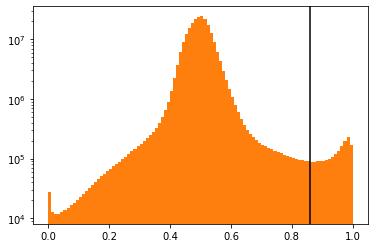

In [ ]:
# # Distribution of predictions on all windows
plt.hist(preds[valid_window_idx], bins=100, range=(0, 1), color=colors[1])
plt.yscale('log')
plt.axvline(x=0.86, color='black')
plt.show()
plt.close()

# # Distribution of predictions on N free windows
# plt.hist(preds[valid_window_idx], bins=100, range=(0, 1))
# plt.show()
# plt.close()


In [ ]:
# CTCF_strange_peaks = other_chr_peaks[peak_lengths == 810]
# print(CTCF_strange_peaks.shape, 'strange peaks')
# strange_peaks_indices = CTCF_strange_peaks[:, :1] + np.expand_dims(np.arange(810), axis=0)
# strange_peaks_one_hot = one_hot_chr[strange_peaks_indices]
# strange_peaks_seq = utils.one_hot_to_seq(strange_peaks_one_hot)
# utils.write_fasta(strange_peaks_seq, f'{data_dir}/CTCF/raw_data/peaks/strange_peaks_seqs.fasta')

### Metaplots

Clustermap on peaks

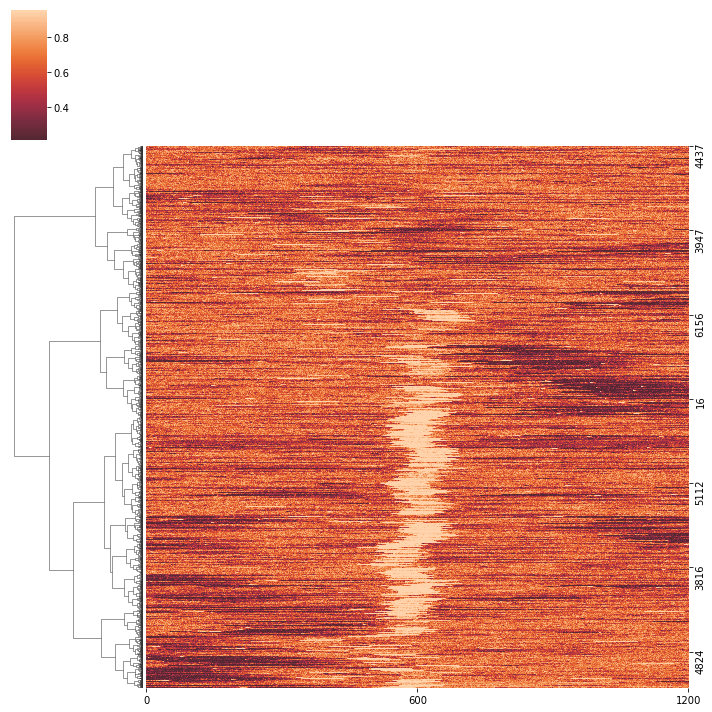

In [ ]:
# Metaplot of predictions over mid peaks
mid_peaks = (chr_peaks[:, 0] + chr_peaks[:, 1]) // 2
window_half_size = 600
clust, means, window = utils.metaplot_over_indices(preds, mid_peaks, window_half_size, plot='clustermap', res_dir=f'{writing_dir}/{data}/results/{model_name}', data=data, chr=f'chr{chr_id}')

Metaplot on peaks

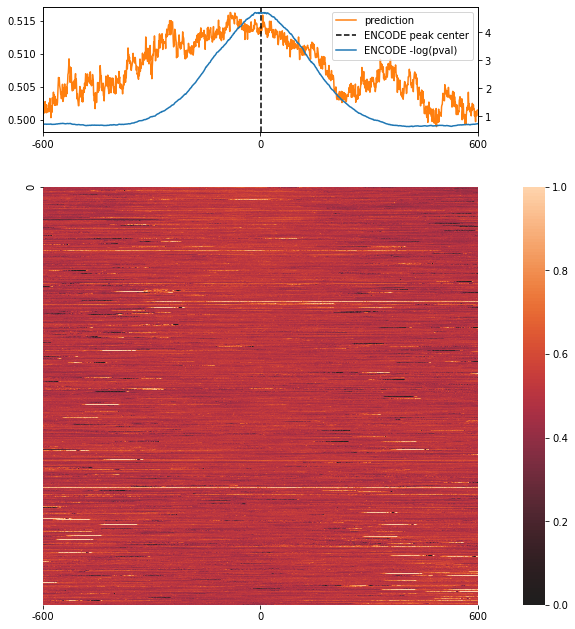

In [ ]:
# Metaplot of predictions over mid peaks
# chr_peaks810 = chr_peaks[peak_lengths == 810]
# chr_peaks_reg = chr_peaks[peak_lengths != 810]
# alt_chr_peaks810 = alt_chr_peaks[alt_peak_lengths == 810]
# alt_chr_peaks_reg = alt_chr_peaks[alt_peak_lengths != 810]
mid_peaks = (chr_peaks[:, 0] + chr_peaks[:, 1]) // 2
window_half_size = 600
corrs, means, window = utils.metaplot_over_indices(preds, mid_peaks, window_half_size, label='prediction', compare=(p_vals, 'ENCODE -log(pval)'), plot='heatmap', res_dir=f'{writing_dir}/{data}/results/{model_name}', data=data, chr=f'chr{chr_id}')

Clustermap cluster analysis

In [ ]:
n_clusters = 5
cluster_idx = cut_tree(clust.dendrogram_row.linkage, n_clusters).ravel()
clusters = [np.where(cluster_idx == i)[0] for i in range(n_clusters)]

clust_order = np.array(clust.dendrogram_row.reordered_ind)
samples = [np.where(clust_order == cluster[0])[0] for cluster in clusters]
print('cluster indices ordered from top to bottom', np.argsort(samples, axis=0).ravel())

mean_order = np.argsort(corrs)[::-1]
cluster_idx_mean_order = cluster_idx[mean_order]
plt.scatter(np.arange(len(mean_order)), cluster_idx_mean_order, marker='.')
plt.show()
plt.close()

Predicted signal over chose peak

(937838, 938598, 1000)


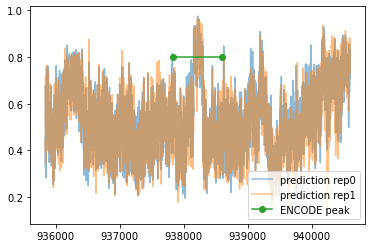

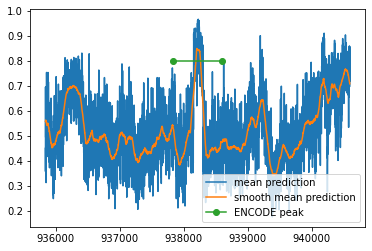

In [ ]:
# plot of predictions over chosen peak
i = 13
peak_start, peak_end, score = chr_peaks[i]
print((peak_start, peak_end, score))
window = np.arange(peak_start-2000, peak_end+2000)
# both replicas
plt.plot(window, preds0[window], label='prediction rep0', alpha=0.5)
plt.plot(window, preds1[window], label='prediction rep1', alpha=0.5)
plt.plot([peak_start, peak_end], [0.8, 0.8], marker = 'o', label='ENCODE peak')
plt.legend(loc='lower right')
plt.show()
plt.close()
# mean vs smooth mean
plt.plot(window, preds[window], label='mean prediction')
plt.plot(window, smooth[window], label='smooth mean prediction')
plt.plot([peak_start, peak_end], [0.8, 0.8], marker = 'o', label='ENCODE peak')
plt.legend(loc='lower right')
plt.show()
plt.close()

### Peak calling

Length of predicted peaks

15455 peaks found
highest length peak: 2497


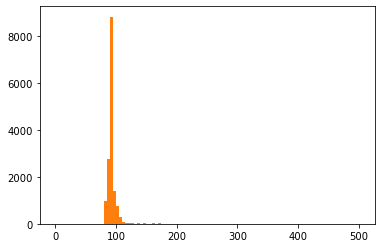

In [ ]:
# Find peaks in prediction with custom function and plot lengths
pred_thres = 0.86
pred_peaks = utils.find_peaks(preds, pred_thres=pred_thres, length_thres=80, tol=20)
lengths = np.sort(np.diff(pred_peaks, axis=1).ravel())
distances = np.sort(pred_peaks[1:, 0] - pred_peaks[:-1, 1])  # check distances between peaks
print(pred_peaks.shape[0], 'peaks found')
MAX=500
print('highest length peak:', np.max(lengths))
plt.hist(lengths, bins=100, range=(-0.5, MAX+0.5), color=colors[1])
# plt.yscale('log')
# plt.xscale('log')
plt.show()
plt.close()

Overlap between peaks

3 chr peaks overlap with pred peaks
5 pred peaks overlap with chr peaks
695 chr peaks do not overlap
15450 pred peaks do not overlap


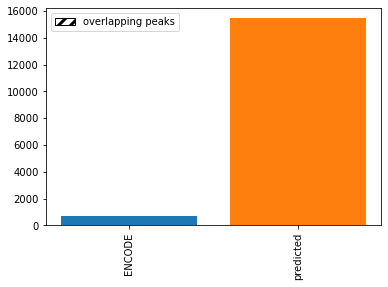

In [ ]:
# find overlaps between predicted peaks and ENCODE peaks
(chr_overlap, pred_overlap), (chr_non_overlap, pred_non_overlap) = utils.overlapping_peaks(chr_peaks, pred_peaks)
print(len(chr_overlap), 'chr peaks overlap with pred peaks')
print(len(pred_overlap), 'pred peaks overlap with chr peaks')
print(len(chr_non_overlap), 'chr peaks do not overlap')
print(len(pred_non_overlap), 'pred peaks do not overlap')
peaks = [len(chr_overlap), len(pred_overlap)]
peaks2 = [len(chr_non_overlap), len(pred_non_overlap)]
overlapping_peaks[data] = [peaks, peaks2]
# Plot overlapping peaks
plt.rcParams['hatch.linewidth'] = 3.0
pos = np.arange(2)
fig, ax = plt.subplots()
ax.bar(pos, peaks, edgecolor='black', color=colors, hatch=['/'])
ax.bar(pos, peaks2, bottom=peaks, color=colors)
ax.set_xticks(pos)
ax.set_xticklabels(['ENCODE', 'predicted'], rotation='vertical')
ax.legend(handles=[mpl.patches.Patch(facecolor='none', edgecolor='black', hatch='//')], labels=['overlapping peaks'])
plt.show()
plt.close()

In [ ]:
overlapping_peaks

{'CTCF': [[2585, 2682], [980, 2988]],
 'H3K27ac': [[1449, 2674], [3121, 3780]],
 'H3K27me3': [[425, 880], [2898, 4804]],
 'H3K9me3': [[3, 5], [695, 15450]]}

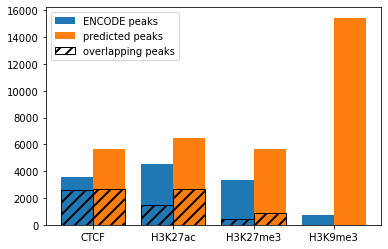

In [ ]:
plt.rcParams['hatch.linewidth'] = 2.0
major_labels = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K9me3']
p_os, p_nos, c_os, c_nos = [], [], [], []
for key in major_labels:
    (c_o, p_o), (c_no, p_no) = overlapping_peaks[key]
    p_os.append(p_o)
    p_nos.append(p_no)
    c_os.append(c_o)
    c_nos.append(c_no)
pos = np.arange(4)*2.5
width = 1
fig, ax = plt.subplots()
ax.bar(pos - width/2, c_os, width, edgecolor='black', color=colors[0], hatch=['//'])
ax.bar(pos - width/2, c_nos, width, bottom=c_os, color=colors[0], label='ENCODE peaks')
ax.bar(pos + width/2, p_os, width, edgecolor='black', color=colors[1], hatch=['//'])
ax.bar(pos + width/2, p_nos, width, bottom=p_os, color=colors[1], label='predicted peaks')

ax.set_xticks(pos)
ax.set_xticklabels(major_labels)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles + [mpl.patches.Patch(facecolor='none', edgecolor='black', hatch='//')], labels + ['overlapping peaks'])
plt.show()
plt.close()

Metaplot only on overlap

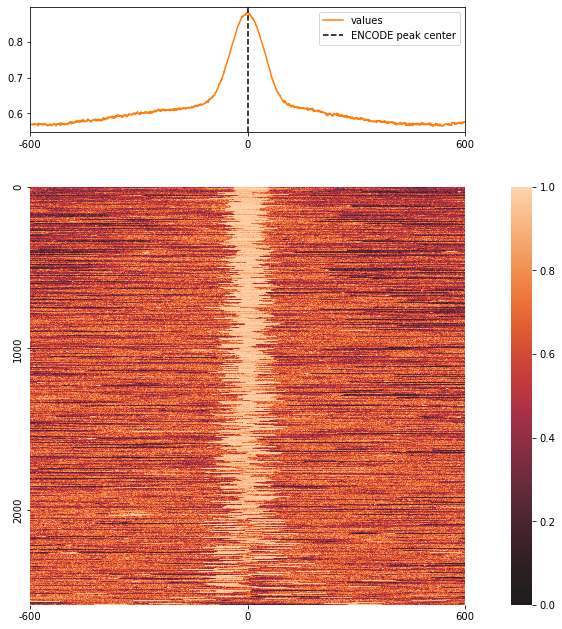

In [ ]:
# Metaplot of predictions over mid peaks
peaks = np.array(chr_overlap)
lengths = np.diff(peaks[:, :2], axis=1).ravel()
# print(len(peaks[lengths != 810]), len(peaks[lengths == 810]))
mid_peaks = (peaks[:, 0] + peaks[:, 1]) // 2
window_half_size = 600
corrs, means, window = utils.metaplot_over_indices(preds, mid_peaks, window_half_size, plot='heatmap')

Metaplot only on non-overlap

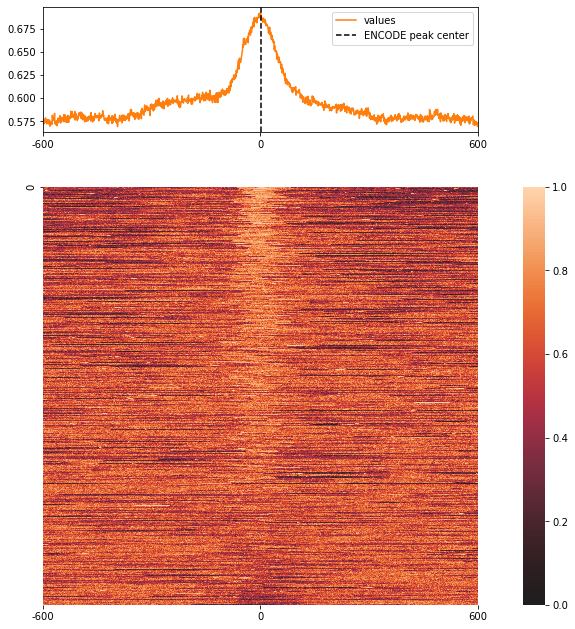

In [ ]:
# Metaplot of predictions over mid peaks
peaks = np.array(chr_non_overlap)
lengths = np.diff(peaks[:, :2], axis=1).ravel()
# print(len(peaks[lengths != 810]), len(peaks[lengths == 810]))
# peaks = peaks[lengths != 810]
mid_peaks = (peaks[:, 0] + peaks[:, 1]) // 2
window_half_size = 600
corrs, means, window = utils.metaplot_over_indices(preds, mid_peaks, window_half_size, plot='heatmap')

Predicted signal on chosen peak with predicted peak too

(869305, 870506, 1000)


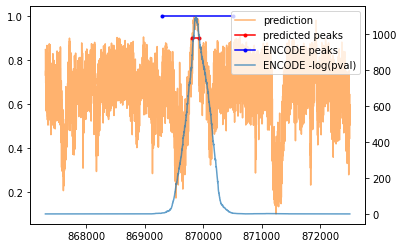

In [ ]:
# plot predicted and encode peaks on predicted signal
i = 5
peak_start, peak_end, *score = chr_peaks[i]
print((peak_start, peak_end, *score))
window = np.arange(peak_start-2000, peak_end+2000)
pred_peaks_to_show = utils.find_peaks_in_window(pred_peaks, peak_start-2000, peak_end+2000)
chr_peaks_to_show = utils.find_peaks_in_window(chr_peaks, peak_start-2000, peak_end+2000)

# plot peaks and preds
ax1 = plt.subplot()
ax1.plot(window, preds[window], label='prediction', alpha=0.6, color=colors[1])
ax2 = ax1.twinx()
ax2.plot(window, p_vals[window], label='ENCODE -log(pval)', alpha=0.7)
for id, (start, end, *_) in enumerate(pred_peaks_to_show):
    if id == 0:
        ax1.plot([start, end], [pred_thres, pred_thres], marker = '.', color='red', label='predicted peaks')
    else:
        ax1.plot([start, end], [pred_thres, pred_thres], marker = '.', color='red')
for id, (start, end, *_) in enumerate(chr_peaks_to_show):
    if id == 0:
        ax1.plot([start, end], [1, 1], marker = '.', color='blue', label='ENCODE peaks')
    else:
        ax1.plot([start, end], [1, 1], marker = '.', color='blue')
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2)
plt.show()
plt.close()

In [ ]:
# plot prediction signal vs fold change and p-value
# i = 3
peak_start, peak_end, *score = pred_non_overlap[i]
print(peak_start, peak_end, *score)
window = np.arange(peak_start-2000, peak_end+2000)
ax1 = plt.subplot()
ax1.plot(window, smooth[window], label='prediction', alpha=0.5)
ax1.plot([peak_start, peak_end], [pred_thres, pred_thres], marker = 'o', label='ENCODE peak')
ax2 = ax1.twinx()
ax2.plot(window, p_vals[window], label='p_value', alpha=0.5, color='black')
ax3 = ax1.twinx()
ax3.plot(window, log_fc[window], label='logFC', alpha=0.5, color='red')
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
plt.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3, loc='lower right')
plt.show()
plt.close()

### Repeats

In [ ]:
# load repeat annotation
window_size=101
repeats = utils.parse_repeats(f'{data_dir}/Human/annotations/repeats/hg38.fa.out', window_size)
chr_repeats = repeats[f'{chr_id}']

In [ ]:
print(chr_repeats.keys())
all_chr_repeats = np.array([rep for array in chr_repeats.values() for rep in array])
lengths = np.diff(all_chr_repeats, axis=1).ravel()
print(np.sum(lengths), 'bases in repeats')
print(len(one_hot_chr), f'bases in chr{chr_id}')

dict_keys(['Simple_repeat', 'Satellite/telo', 'LINE/L1', 'DNA/hAT-Charlie', 'SINE/MIR', 'LINE/L2', 'LINE/CR1', 'LTR/ERVL-MaLR', 'SINE/Alu', 'DNA/hAT', 'LTR/ERVL', 'LTR', 'LTR/ERV1', 'DNA/hAT-Tip100', 'Low_complexity', 'DNA/TcMar-Tigger', 'LTR/ERVL?', 'LTR/ERV1?', 'LINE/RTE-X', 'LTR?', 'LTR/ERVK', 'snRNA', 'DNA/MULE-MuDR', 'tRNA', 'DNA?', 'LTR/Gypsy', 'DNA/hAT-Blackjack', 'Retroposon/SVA', 'Satellite', 'srpRNA', 'DNA/hAT-Ac', 'rRNA', 'DNA/TcMar-Tc2', 'SINE/tRNA-Deu', 'LINE/RTE-BovB', 'SINE/5S-Deu-L2', 'DNA/PiggyBac', 'DNA/hAT?', 'Unknown', 'DNA/TcMar-Mariner', 'RC/Helitron', 'LTR/Gypsy?', 'SINE/tRNA-RTE', 'SINE/tRNA', 'DNA/hAT-Tip100?', 'DNA', 'LINE/Penelope', 'LINE/Dong-R4', 'scRNA', 'RNA', 'DNA/PiggyBac?', 'Satellite/centr', 'DNA/TcMar?', 'RC?/Helitron?', 'DNA/TcMar', 'DNA/hAT-Tag1', 'DNA/Merlin', 'DNA/TcMar-Pogo', 'SINE?/tRNA', 'SINE?', 'DNA/PIF-Harbinger'])
118782675 bases in repeats


NameError: name 'one_hot_chr' is not defined

In [ ]:
pred_peaks_in_repeats = {}
for family in chr_repeats.keys():
    (pred_peaks_in_repeats[family], _), _ = utils.overlapping_peaks(pred_peaks, chr_repeats[family])
chr_peaks_in_repeats = {}
for family in chr_repeats.keys():
    (chr_peaks_in_repeats[family], _), _ = utils.overlapping_peaks(chr_peaks_reg, chr_repeats[family])
# chr_peaks_reg_in_repeats = {}
# for family in chr_repeats.keys():
#     (chr_peaks_reg_in_repeats[family], _), _ = utils.overlapping_peaks(chr_peaks_reg, chr_repeats[family])
# chr_peaks810_in_repeats = {}
# for family in chr_repeats.keys():
#     (chr_peaks810_in_repeats[family], _), _ = utils.overlapping_peaks(chr_peaks810, chr_repeats[family])

In [ ]:
n_pred_peaks = {key: len(value) for key, value in pred_peaks_in_repeats.items()}
n_chr_peaks = {key: len(value) for key, value in chr_peaks_in_repeats.items()}

zero_keys = []
for key, value in n_pred_peaks.items():
    if value == 0 and n_chr_peaks[key] == 0:
        zero_keys.append(key)
for key in zero_keys:
    n_pred_peaks.pop(key)
    n_chr_peaks.pop(key)
# n_chr_peaks_reg = {key: len(value) for key, value in chr_peaks_reg_in_repeats.items()}
# n_chr_peaks810 = {key: len(value) for key, value in chr_peaks810_in_repeats.items()}
# n_families = 0
# for family, value in n_chr_peaks.items():
#     if '?' not in family:
#         print(family, value)
#         n_families += 1
# print(n_families, 'families')

Peaks and predicted peaks in repeats

5175 peaks in repeats in ENCODE CTCF
2207 peaks in repeats in predicted CTCF


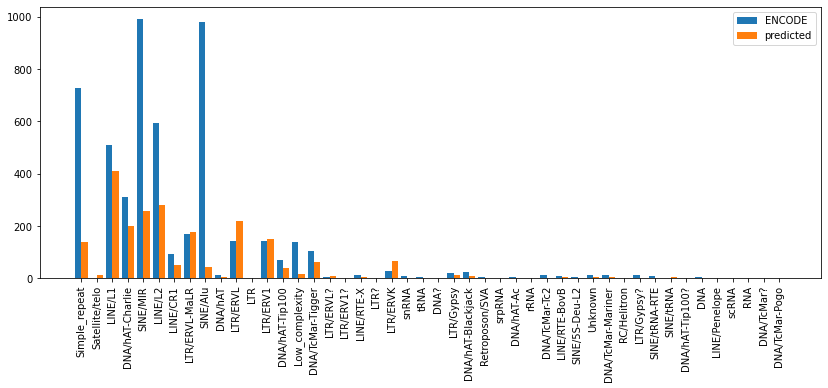

In [ ]:
families, peaks = zip(*n_chr_peaks.items())
families2, peaks2 = zip(*n_pred_peaks.items())
print(sum(peaks), f'peaks in repeats in ENCODE {data}')
print(sum(peaks2), f'peaks in repeats in predicted {data}')
assert(families == families2)
pos = np.arange(len(families))*2.5
width = 1
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(pos - 0.5, peaks, width, label='ENCODE')
ax.bar(pos + 0.5, peaks2, width, label='predicted')
# ax.set_ylim(0, 2500)
ax.set_xticks(pos)
ax.set_xticklabels(families, rotation='vertical')
plt.legend()
plt.show()
plt.close()

Just peaks in repeats

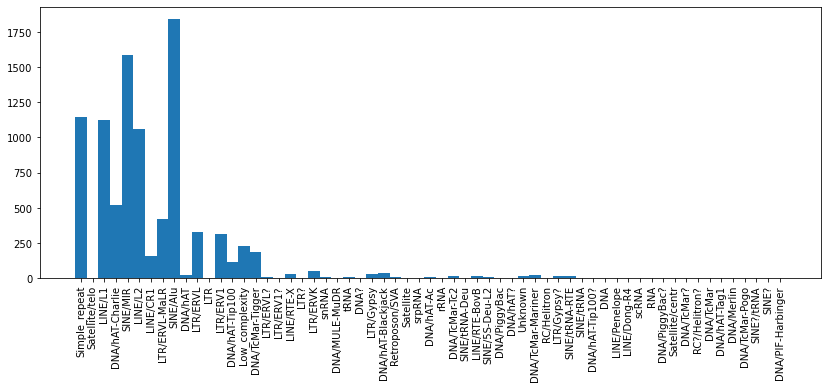

In [ ]:
families, peaks = zip(*n_chr_peaks.items())
pos = np.arange(len(families))
width = 1
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(pos, peaks, width)
ax.set_xticks(pos)
ax.set_xticklabels(families, rotation='vertical')
plt.show()
plt.close()

## Loading predictions on T2T

In [4]:
genome = "T2T-CHM13v2.0"
chr_id = 1
with np.load(f"{data_dir}/Human/assembly/{genome}/{genome}.npz") as f:
    one_hot_chr = f[f'{chr_id}']
window_size = 101
print('All windows:', len(one_hot_chr)-window_size+1)

All windows: 248387228


In [5]:
data = 'Judith-H3K9me3'
genome = "T2T-CHM13v2.0"
chr_id = 1
model_name = 'model_inception3.1'
with np.load(f'{data_dir}/{data}/results/{model_name}/preds_on_{genome}.npz') as f:
    preds3_1 = f[f'chr{chr_id}']
# model_name = 'model_inception3.0'
# with np.load(f'{data_dir}/{data}/results/{model_name}/preds_on_{genome}.npz') as f:
#     preds3_0 = f[f'chr{chr_id}']
model_name = 'model_inception2.3'
with np.load(f'{data_dir}/{data}/results/{model_name}/preds_on_{genome}.npz') as f:
    preds2_3 = f[f'chr{chr_id}']
preds = preds3_1

In [ ]:
def bin_preds(preds, bins):
    if len(preds)%bins == 0:
        binned_preds = np.mean(utils.strided_window_view(preds, bins, bins), axis=1)
    else:
        binned_preds = np.append(np.mean(utils.strided_window_view(preds, bins, bins), axis=1), np.mean(preds[-(len(preds)%bins):]))
    return binned_preds


def full_genome_binned_preds(data,
                             genome,
                             model_name,
                             threshold,
                             bins,
                             verbose=True,
                             data_dir='shared_folder'):
    if genome == 'T2T-CHM13v2.0':
        lengths = T2T_lengths
        chr_ids = T2T_chr_ids
    elif genome == 'GRCh38':
        lengths = GRCh38_lengths
        chr_ids = hg38_chr_ids
    # merging chromosomes
    binned_lengths = np.array([x // bins + 1 for x in lengths.values()])
    seperators = np.cumsum(binned_lengths)
    total_length = seperators[-1]
    full_binned_preds = np.zeros(total_length)
    for i, chr_id in enumerate(chr_ids.keys()):
        with np.load(f'{data_dir}/{data}/results/{model_name}/preds_on_{genome}.npz') as f:
            preds = f[f'chr{chr_id}']
        binned_preds = bin_preds(preds, bins)
        full_binned_preds[seperators[i]-len(binned_preds):seperators[i], :] = binned_preds
    return full_binned_preds, seperators

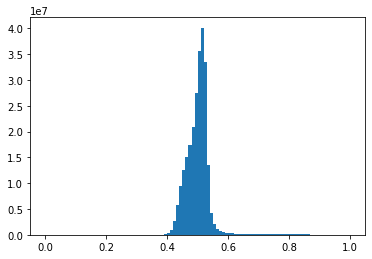

In [459]:
# Distribution of predictions on all windows
# plt.hist(preds2_3, bins=100, range=(0, 1), alpha=0.5, label='model2.3')#, color=colors[1])
plt.hist(preds3_1, bins=100, range=(0, 1), alpha=1, label='model3.1')
# plt.yscale('log')
# plt.axvline(x=0.5, color='black', label='t0.5')
# plt.axvline(x=0.6, color='red', label='t0.55')
# plt.legend()
plt.show()
plt.close()

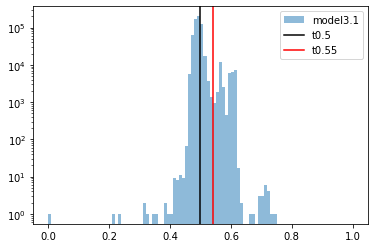

In [450]:
plt.hist(binned_preds, bins=100, range=(0, 1), alpha=0.5, label='model3.1')
plt.yscale('log')
plt.axvline(x=0.5, color='black', label='t0.5')
plt.axvline(x=0.54, color='red', label='t0.55')
plt.legend()
plt.show()
plt.close()

In [244]:
peaks_dict = utils.parse_bed_peaks(f'{data_dir}/{data}/results/alignments/{genome}/macs_output/D1145C43_trimmed_paired_T2T_peaks.broadPeak', window_size)

(1026, 3) total peaks in Judith-H3K9me3


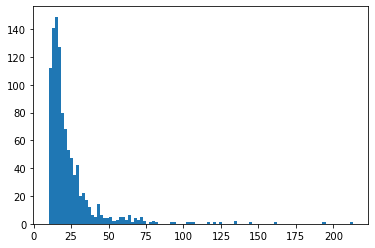

452 peaks over 20


In [245]:
chr_peaks = peaks_dict[utils.T2T_chr_ids[f'{chr_id}']]
print(chr_peaks.shape, f'total peaks in {data}')
plt.hist(chr_peaks[:,2], bins=100)
plt.show()
plt.close()
score_thres = 20
high_peaks, = np.where(chr_peaks[:, 2] >= score_thres)
print(len(high_peaks), f'peaks over {score_thres}')

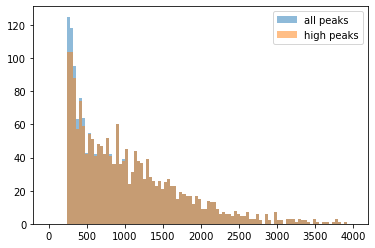

Number of bases in peaks: 2072371


In [200]:
# Distribution of peak lengths
peak_lengths = np.diff(chr_peaks[:, :2], axis=1).ravel()
high_peak_lengths = np.diff(chr_peaks[high_peaks, :2], axis=1).ravel()
plt.hist(peak_lengths, bins=100, range=(0, 4000), alpha=0.5, label='all peaks')
plt.hist(high_peak_lengths, bins=100, range=(0, 4000), alpha=0.5, label='high peaks')
plt.legend()
plt.show()
plt.close()
# Total peak length
print('Number of bases in peaks:', np.sum(peak_lengths))

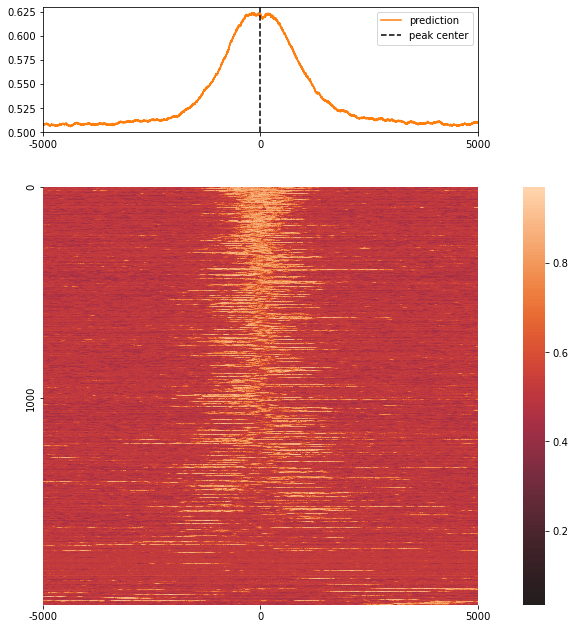

In [201]:
# Metaplot of predictions over mid peaks
mid_peaks = (chr_peaks[:, 0] + chr_peaks[:, 1]) // 2
window_half_size = 5000
corrs, means, window = plot_utils.metaplot_over_indices(
    preds,
    mid_peaks,
    window_half_size,
    label='prediction',
    plot='heatmap',
    res_dir=f'{writing_dir}/{data}/results/{model_name}',
    data=data,
    chr=f'chr{chr_id}')

(450255, 450625, 30)


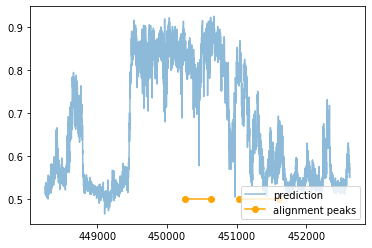

In [227]:
# plot of predictions over chosen peak
i = 10
peak_start, peak_end, score = chr_peaks[i]
print((peak_start, peak_end, score))
window = np.arange(peak_start-2000, peak_end+2000)
# plot prediction
axes = [plt.subplot()]
axes[0].plot(window, preds3_1[window], label='prediction', alpha=0.5)

chr_peaks_to_show = utils.find_peaks_in_window(chr_peaks, window[0], window[-1]+1)
for id, (start, end, *_) in enumerate(chr_peaks_to_show):
    if id == 0:
        axes[0].plot([start, end], [0.5, 0.5], marker = 'o', color='orange', label='alignment peaks')
    else:
        axes[0].plot([start, end], [0.5, 0.5], marker = 'o', color='orange')
handles, labels = plot_utils.add_legend(axes)
plt.legend(handles, labels, loc='lower right')
plt.show()
plt.close()

340 peaks found
highest length peak: 5644


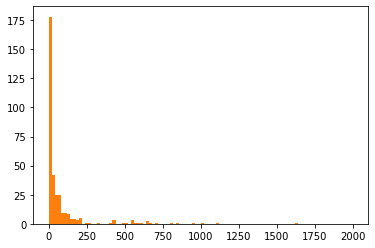

In [452]:
# Find peaks in prediction with custom function and plot lengths
pred_thres = 0.54
pred_peaks = utils.find_peaks(binned_preds, pred_thres=pred_thres, length_thres=1, tol=1)
lengths = np.sort(np.diff(pred_peaks, axis=1).ravel())
distances = np.sort(pred_peaks[1:, 0] - pred_peaks[:-1, 1])  # check distances between peaks
print(pred_peaks.shape[0], 'peaks found')
MAX=2000
print('highest length peak:', np.max(lengths))
plt.hist(lengths, bins=100, color=colors[1], range=(-0.5, MAX+0.5))
# plt.yscale('log')
# plt.xscale('log')
plt.show()
plt.close()

In [7]:
# binning and and dealing with last bin by hand
bins = 5000
importlib.reload(utils)
binned_preds, _ = utils.full_genome_binned_preds(data, genome, model_name, bins, data_dir=data_dir)
df, seperators = utils.merging_full_genome(data, genome, 500, bins, data_dir=data_dir)
df

43531/623468 significantly enriched bins in Judith-H3K9me3
39286/623468 significantly enriched bins in Judith-H3K9me3 when chromosome local


pos  ip_binned_signal  ctrl_binned_signal  log_ratio  \
0              0.0              89.0                61.0   0.164060   
1           5000.0             114.0                89.0   0.107515   
2          10000.0              94.0                97.0  -0.013644   
3          15000.0             128.0               107.0   0.077826   
4          20000.0             110.0                99.0   0.045757   
...            ...               ...                 ...        ...   
623463  62440000.0              60.0                45.0   0.124939   
623464  62445000.0              62.0                35.0   0.248324   
623465  62450000.0              55.0                37.0   0.172161   
623466  62455000.0              53.0                33.0   0.205762   
623467  62460000.0               0.0                 0.0        NaN   

               KL  binom_p_value  binom_q_value   norm_ip_cov  norm_ctrl_cov  \
0       14.601355       0.116943       0.557945  1.666687e-06   1.393291e-06   
1       12.256692       0.309038       0.976616  2.134857e-06   2.032835e-06   
2       -1.282525       0.925541       1.000000  1.760321e-06   2.215561e-06   
3        9.961753       0.489282       1.000000  2.397033e-06   2.443970e-06   
4        5.033324       0.696632       1.000000  2.059950e-06   2.261243e-06   
...           ...            ...            ...           ...            ...   
623463   7.496324       0.684807       1.000000  1.123609e-06   1.027838e-06   
623464  15.396066       0.187074       1.000000  1.161063e-06   7.994294e-07   
623465   9.468853       0.480533       1.000000  1.029975e-06   8.451111e-07   
623466  10.905382       0.348933       1.000000  9.925213e-07   7.537477e-07   
623467        NaN       1.000000       1.000000  0.000000e+00   0.000000e+00   

        binom_p_value_complete  binom_q_value_complete  -log(qvalue_complete)  \
0                     0.159317                0.628218               0.201890   
1                     0.392261                1.000000              -0.000000   
2                     0.951792                1.000000              -0.000000   
3                     0.585348                1.000000              -0.000000   
4                     0.771456                1.000000              -0.000000   
...                        ...                     ...                    ...   
623463                0.362891                1.000000              -0.000000   
623464                0.046262                0.283798               0.546990   
623465                0.204464                0.730471               0.136397   
623466                0.127568                0.545305               0.263360   
623467                1.000000                1.000000              -0.000000   

        -log(pvalue_complete)  significantly_enriched  
0                    0.797739                   False  
1                    0.406425                   False  
2                    0.021458                   False  
3                    0.232586                   False  
4                    0.112689                   False  
...                       ...                     ...  
623463               0.440224                   False  
623464               1.334778                   False  
623465               0.689383                   False  
623466               0.894257                   False  
623467              -0.000000                   False  

[623468 rows x 14 columns]

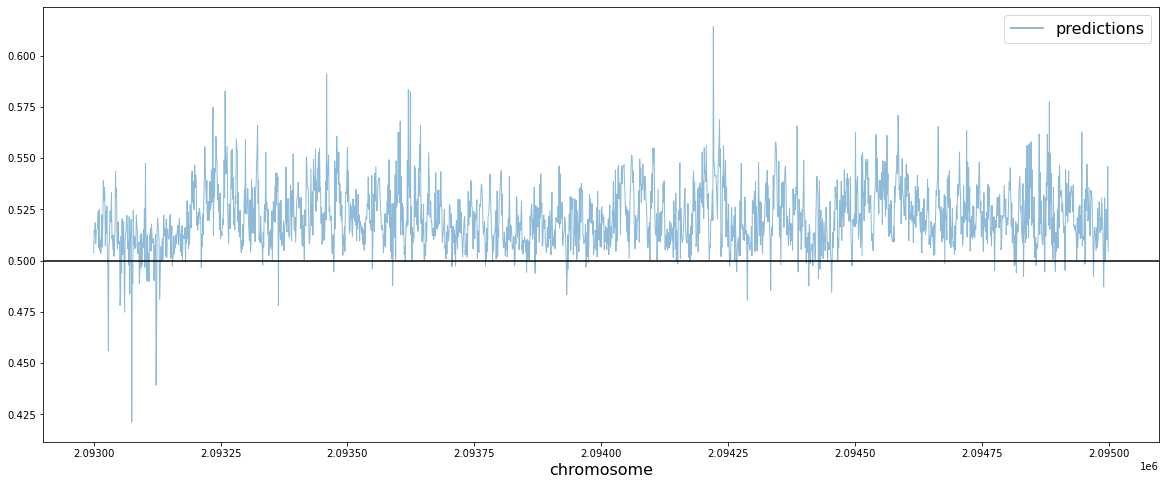

In [43]:
start = 2_093_000 # 0 # 143_000_000 # 
end = 2_095_000 # seperators[0]*bins # 145_000_000 # 

if genome == 'T2T-CHM13v2.0':
    lengths = utils.T2T_lengths
    chr_ids = utils.T2T_chr_ids
elif genome == 'GRCh38':
    lengths = utils.GRCh38_lengths
    chr_ids = utils.hg38_chr_ids
kwargs = {'alpha':0.5,
          'linewidth':1}
plt.figure(figsize=(20, 8))
axes = [plt.subplot()]
# predictions
axes[0].plot(np.arange(start, end), preds[start:end], label='predictions', alpha=0.5, linewidth=1) # full
# plot_utils.binned_plot(binned_preds, axes[0], start, end, bins, label='binned_preds', **kwargs) # binned
axes[0].axhline(y=0.5, color='black')
# binned alignment
# axes.append(axes[0].twinx())
# column = '-log(qvalue_complete)'
# plot_utils.binned_plot(df[column], axes[1], start, end, bins,
#                        label=column, color=colors[1], **kwargs)
# column = 'norm_ctrl_cov'
# plot_utils.binned_plot(df[column], axes[1], start, end, bins,
#                        label=column, color=colors[2], **kwargs)
# add peaks
# chr_peaks_to_show = utils.find_peaks_in_window(chr_peaks, start, end)
# max_peak_y = 0.7
# max_peak_score = np.max(chr_peaks[:, 2])
# for id, (start, end, score) in enumerate(chr_peaks_to_show):
#     peak_y = 0.5 + (max_peak_y-0.5) * score/max_peak_score
#     if id == 0:
#         axes[0].plot([start, end], [peak_y, peak_y], marker = '.', color='orange', label='macs peaks', markeredgewidth=0.5, alpha=0.5)
#     else:
#         axes[0].plot([start, end], [peak_y, peak_y], marker = '.', color='orange', markeredgewidth=0.5, alpha=0.5)
# legend
# for sep in seperators[:-1]:
#     plt.axvline(x=sep*bins, color='black', linestyle='--', alpha=0.5)
# axes[0].set_xticks(utils.moving_average(np.insert(seperators*bins, 0, 0))[:])
# axes[0].set_xticklabels(list(chr_ids.keys())[:], fontsize=16)
handles, labels = plot_utils.add_legend(axes)
leg = plt.legend(handles, labels, fontsize=16)
for line in leg.get_lines():
    line.set_linewidth(2)
axes[0].set_xlabel('chromosome', fontsize=16)
# axes[0].set_ylabel(prediction, fontsize=16)
plt.show()
plt.close()

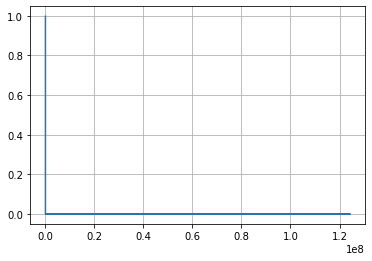

In [46]:
from scipy.fft import fft, fftfreq
def freq_distrib(signal, sample_spacing=1):
    # Number of sample points
    N = len(signal)
    # sample spacing
    T = sample_spacing / N
    yf = 2.0/N * np.abs(fft(signal)[0:N//2])
    xf = fftfreq(N, T)[:N//2]
    return xf, yf

xf, yf = freq_distrib(preds, sample_spacing=1.0)
plt.plot(xf, yf)
# plt.ylim(top=0.05)
plt.grid()
plt.show()

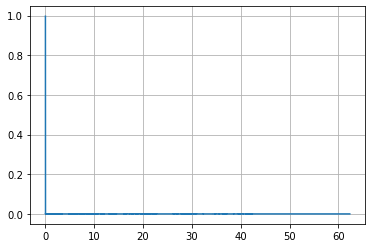

In [47]:
xf, yf = freq_distrib(binned_preds, sample_spacing=bins)
plt.plot(xf, yf)
# plt.ylim(top=0.05)
plt.grid()
plt.show()

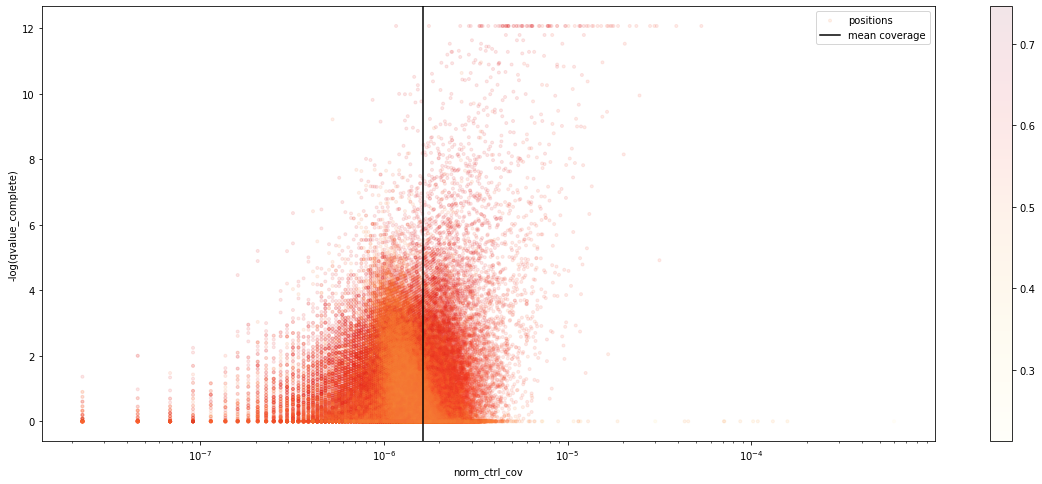

610975 points drawn


In [387]:
start = 0
end = seperators[-2]*bins

plt.figure(figsize=(20, 8))
x_column = 'norm_ctrl_cov'
y_column = '-log(qvalue_complete)'
x_values = df[x_column][start//bins:end//bins]
y_values = df[y_column][start//bins:end//bins]
c_values = binned_preds[start//bins:end//bins]
with_signal = y_values != -1
mean_coverage = np.mean(x_values[with_signal])
plt.scatter(x_values[with_signal], y_values[with_signal], c=c_values[with_signal], cmap='YlOrRd', label='positions', marker='.', alpha=0.1)
plt.axvline(x = mean_coverage, color='black', label='mean coverage')
# plt.xlim(left=0, right=200)
# plt.ylim(bottom=0, top=6)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.xscale('log')
plt.legend()
plt.colorbar()
plt.show()
plt.close()
print(np.sum(with_signal), 'points drawn')

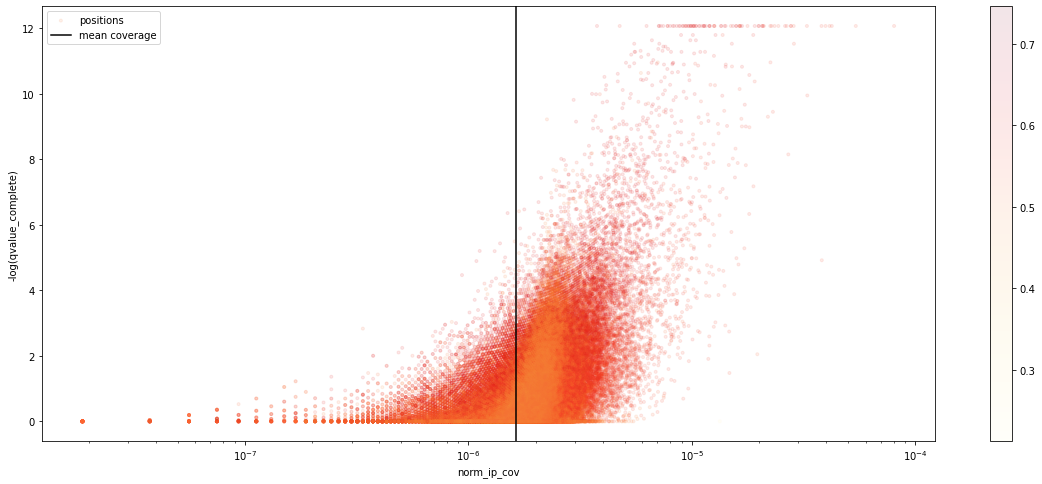

610975 points drawn


In [385]:
start = 0
end = seperators[-2]*bins

plt.figure(figsize=(20, 8))
x_column = 'norm_ip_cov'
y_column = '-log(qvalue_complete)'
x_values = df[x_column][start//bins:end//bins]
y_values = df[y_column][start//bins:end//bins]
c_values = binned_preds[start//bins:end//bins]
with_signal = y_values != -1
mean_coverage = np.mean(x_values[with_signal])
plt.scatter(x_values[with_signal], y_values[with_signal], c=c_values[with_signal], cmap='YlOrRd', label='positions', marker='.', alpha=0.1)
plt.axvline(x = mean_coverage, color='black', label='mean coverage')
# plt.xlim(left=0, right=200)
# plt.ylim(bottom=0, top=6)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.xscale('log')
plt.legend()
plt.colorbar()
plt.show()
plt.close()
print(np.sum(with_signal), 'points drawn')

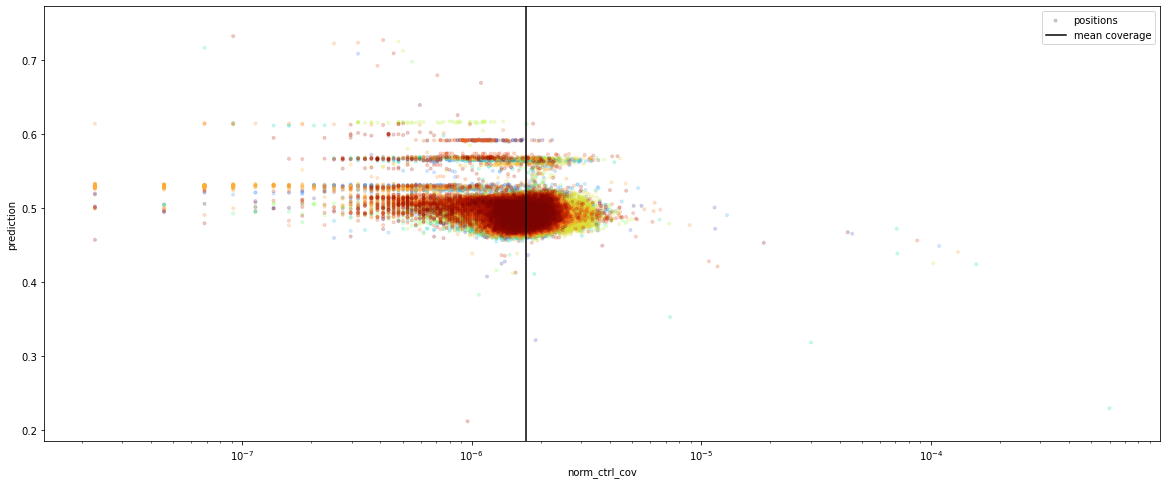

387908 points drawn


In [442]:
with_signal = y_values != 0
plt.figure(figsize=(20, 8))
mean_coverage = np.mean(x_values[~with_signal])
pos_values = np.arange(len(c_values))
# alpha_values = np.zeros(len(c_values))
# start = 0
# end = min(start + 10000, len(c_values))
# alpha_values[start:end] = 0.2
plt.scatter(x_values[~with_signal], c_values[~with_signal], c=pos_values[~with_signal], cmap=plt.cm.get_cmap('turbo'), label='positions', marker='.', alpha=0.2)
plt.axvline(x = mean_coverage, color='black', label='mean coverage')
# plt.xlim(left=0, right=200)
# plt.ylim(bottom=0, top=6)
plt.xlabel(x_column)
plt.ylabel('prediction')
plt.xscale('log')
plt.legend()
plt.show()
plt.close()
print(np.sum(~with_signal), 'points drawn')

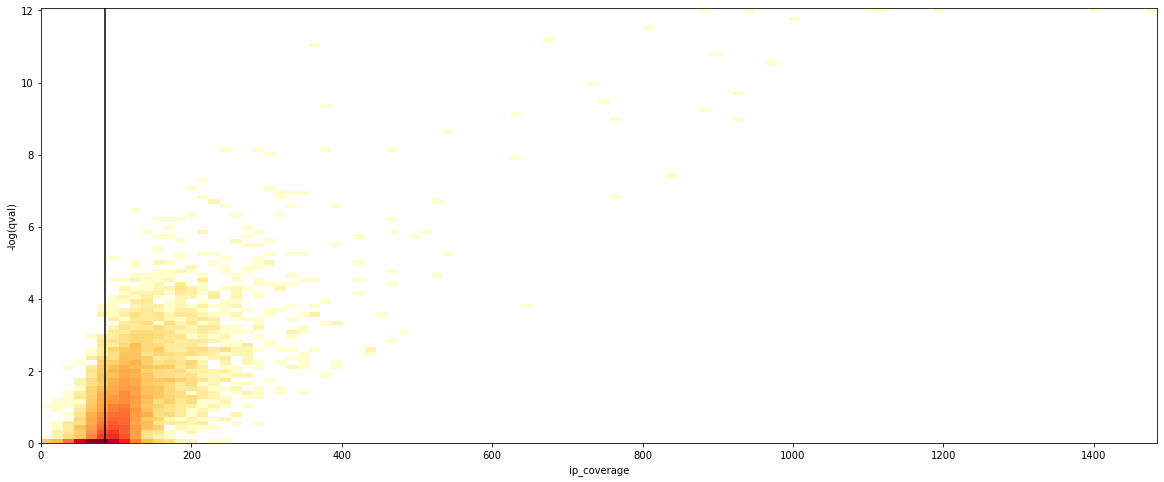

In [324]:
# with_signal = np.ones(len(df[column1][start//bins:end//bins]), dtype=bool)
with_signal = y_values != -1
_, bin_edges_x = np.histogram(x_values[with_signal], bins=100)
_, bin_edges_y = np.histogram(y_values[with_signal], bins=100)
bin_edges = [bin_edges_x, bin_edges_y]
plt.figure(figsize=(20, 8))
plt.hist2d(x_values[with_signal], y_values[with_signal], bins=bin_edges, density=True, cmap=plt.cm.get_cmap('YlOrRd'), norm=mpl.colors.LogNorm())
plt.axvline(x = mean_coverage, color='black', label='mean coverage')
plt.xlabel('ip_coverage')
plt.ylabel('-log(qval)')
# plt.xlim(left=0, right=200)
# plt.ylim(bottom=0, top=6)
plt.show()
plt.close()